In [161]:
import os
import random
import math
import numpy as np
import json
import pprint
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [162]:
# CONSTANTS

# The minimum number of exemplars per category
MIN_PER_CATEGORY = 5

# The maximum number of exemplars per category
MAX_PER_CATEGORY = 40

# The thresholds we are going to test
THRESHOLDS = [math.inf, 3.2, 3.1, 3.0, 2.9, 2.8, 2.7, 2.6]

# force some of the allocated values to match the theory paper
MATCH_PAPER = False

# List of attack categories and exemplar count from theory paper
PAPER_CATEGORY_LIST = {'Loss_of_View': 8, 'Loss_of_Control': 4, 'Denial_of_View': 1,
                       'Denial_of_Control': 5, 'Denial_of_Safety': 3,
                       'Manipulation_of_View': 3, 'Manipulation_of_Control': 5,
                       'Manipulation_of_Sensors': 3, 'Manipulation_of_Safety': 10}

BASE_CASE_MAX_FAILURE = 0.1
BASE_CASE_MAX_TIME_SLEW = 0
MAX_FAILURE = 0.2
MAX_TIME_SLEW = 2
TIME_RATIO_WEIGHT = 0.02
INITIAL_IDS_DETECTION_RATIO = 0.5
IDS_DETECTION_RATIO = 0.1

In [163]:
def create_exemplars(count):
    exemplars = []
    for x in range(count):
        exemplars.append({'r':1, 'd':1, 't':1})
    return exemplars


def calculate_r(prior_rate, max_failure):
    new_rate = (random.random() * max_failure)+(prior_rate-max_failure)
    return max(new_rate, 0)


def calculate_t(prior_basis, max_time_slew):
    new_rate = (random.random() * max_time_slew)+(prior_basis)
    return max(new_rate, 0)

def calculate_d(prior, detection_ratio):
    yes = detection_ratio
    no = 1-yes
    if prior > 0:
        current = np.random.choice(2, 1, p=[yes, no])[0]
        return current
    else:
        return prior


def calculate_s_t(max_failure, max_time_slew, time_weighting, detection_ratio):
    s_t = {'categories': {}, 'total': 0, 'total_time': 0}
    for c in categories:
        s_c = 0
        s_c_time = 0
        for e in categories[c]:
            e['r'] = calculate_r(e['r'], max_failure)
            e['t'] = calculate_t(e['t'], max_time_slew)
            e['d'] = calculate_d(e['d'], detection_ratio)
            s_c += e['r'] * e['d']
            s_c_time += (e['r'] * e['d']) - (e['d']*time_weighting*(e['t'] - 1))
        s_t['categories'][c] = s_c
        s_t['categories'][c + '_time'] = s_c_time
        s_t['total'] += s_c
        s_t['total_time'] += s_c_time
    return s_t

In [164]:
# create the results structure
results = []

# create the category data structure
categories = {}
for c in PAPER_CATEGORY_LIST:
    categories[c] = []
    
if MATCH_PAPER:
    for c in PAPER_CATEGORY_LIST:
        categories[c] = create_exemplars(PAPER_CATEGORY_LIST[c])
else:
    for c in PAPER_CATEGORY_LIST:
        categories[c] = create_exemplars(random.randint(MIN_PER_CATEGORY, MAX_PER_CATEGORY))

In [165]:
exemplar_count = 0
for v in categories.values():
    exemplar_count = exemplar_count + len(v)

print('Total Exemplars: %d' % exemplar_count)

Total Exemplars: 184


In [166]:
# Calculate the base-case scores and store the results
result = calculate_s_t(BASE_CASE_MAX_FAILURE, BASE_CASE_MAX_TIME_SLEW, TIME_RATIO_WEIGHT, 0)
results.append(result)

In [167]:
# cacluate the scores for initial deployment of IDS (larger detection ratio)
result = calculate_s_t(MAX_FAILURE, MAX_TIME_SLEW, TIME_RATIO_WEIGHT, INITIAL_IDS_DETECTION_RATIO)
results.append(result)

In [168]:
# Calculate the remaining scores and store the results
for t in THRESHOLDS[2:]:
    result = calculate_s_t(MAX_FAILURE, MAX_TIME_SLEW, TIME_RATIO_WEIGHT, IDS_DETECTION_RATIO)
    results.append(result)

In [169]:
# pprint.pprint(categories)

In [170]:
# pprint.pprint(results)

In [171]:
scores = []
tscores = []
for r in results:
    scores.append(r['total'])
    tscores.append(r['total_time'])

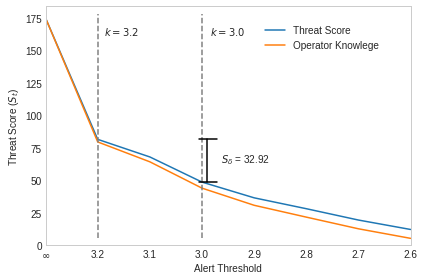

In [172]:
# build the xticks
ticks = []
ticks.append('$\infty$')
for score in THRESHOLDS[1:]:
    ticks.append(str(score))

ax = sns.lineplot(x=ticks, y=scores, sort=False, color='#1f77b4')
plt.xlabel('Alert Threshold')
plt.ylabel('Threat Score ($S_t$)')
ax.set(ylim=(0, exemplar_count), xlim=(0, 7))

delta_text = '$S_\delta$ = {:0.2f}'.format(scores[1]-scores[3])

ax.annotate(delta_text, xy=(4, 5.003566),  xycoords='data',
            xytext=(0.48, 0.39), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            )

ax.annotate('$k=3.2$', xy=(4, 5.003566),  xycoords='data',
            xytext=(0.16, 0.92), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            )

ax.annotate('$k=3.0$', xy=(4, 5.003566),  xycoords='data',
            xytext=(0.45, 0.92), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            )


ax.grid(False)

# create our second plot
sns.lineplot(x=ticks, y=tscores, sort=False, color='#ff7f0e')

ydiv = exemplar_count 
plt.axvline(1.0, 0.03, 0.97, linestyle='--', color='grey', label='FP Threshold')
plt.axvline(3.0, 0.03, 0.97, linestyle='--', color='grey', label='FP Threshold')
plt.axvline(3.1, scores[3]/ydiv, scores[1]/ydiv, linestyle='-', color='black')
plt.axhline(scores[1], 0.42, 0.47, color='black')
plt.axhline(scores[3], 0.42, 0.47, color='black')

# set the legend
ax.legend(['Threat Score', 'Operator Knowlege'], loc=(0.59,0.8))

plt.tight_layout()
plt.savefig('threatsimulation01.png')
plt.savefig('threatsimulation01.pdf')

In [173]:
cat_results = []
max_y = 0
for c in PAPER_CATEGORY_LIST:
    x = {'name': c, 'totals':[]}
    
    for r in results:
        x['totals'].append(r['categories'][c])
        if r['categories'][c] > max_y:
            max_y = r['categories'][c]
    
    cat_results.append(x)
    
max_y = math.ceil(max_y)

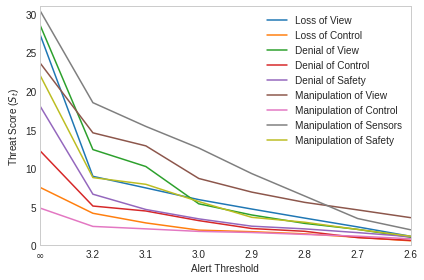

In [174]:
# build the xticks
ticks = []
ticks.append('$\infty$')
for score in THRESHOLDS[1:]:
    ticks.append(str(score))

labels = []
for cr in cat_results:
    labels.append(cr['name'].replace('_', ' '))
    sns.lineplot(x=ticks, y=cr['totals'], sort=False)

plt.xlabel('Alert Threshold')
plt.ylabel('Threat Score ($S_t$)')

ax = plt.gca()
ax.grid(False)
ax.set(ylim=(0, max_y), xlim=(0, 7))


# set the legend
ax.legend(labels)

plt.tight_layout()
plt.savefig('threatsimulationcategories01.png')
plt.savefig('threatsimulationcategories01.pdf')